In [1]:
import h5py
import pylab as pl
import numpy as np
import scipy.stats as sp
import matplotlib as mpl
import networkx
import progressbar

In [2]:
def split_unique_id(unique_id):
    """Splits the ids assign to the subhalos by the merger tree code by snap number and subfind number """
    subfind_number = int(unique_id % 1e6)
    snap_number = int((unique_id - subfind_number) / 1e6)
    
    return snap_number, subfind_number

def get_main_branch_unique_ids(subtree, node):
    """Gets the unique ids of the subhalos belonging to the main branch of the selected subhalo (node)"""
    mpb = [node, ]
    i = 0
    while True:
        succesors = list(subtree.successors(node))
        if len(succesors) == 0:
            break
        node = succesors[0] # select only the first succesor (main branch)
        mpb.append(node)
        
    return mpb

In [3]:
pl.rc('font', size = 20)
pl.rc('legend', fontsize = 20)
sim = h5py.File('/data/cielo/simulations/LG1/LG1.hdf5', 'r')
trees = networkx.read_multiline_adjlist('/data/cielo/simulations/LG1/LG1_tree.dat')

In [4]:
Slist = h5py.File('SatelliteList_V2_withAngles_n100.h5', 'r')
Satellites = Slist['SatelliteList'][()]
Centrals = Slist['SatelliteCentral'][()]
CosCen = Slist['CosCen'][()]
CosVel = Slist['CosVel'][()]
LzL = Slist['LZ_L'][()]

In [5]:
#ok, now the serialized version of the get particles for each Satellite, lets see.
TdayTotalIDs = sim['SnapNumber_128/PartType0/ParticleIDs'][()] # need this first
I= np.identity(3) # and this

In [6]:
def getAllLastP(fofID, centralID):
    """
    get position, masses and abundances of all particles that in past snapshot belong to a given subhalo,
    and a z=0 are located at athe maximum distance of 600 kpc to the subhalo,
    rotated by the velocity and the vector to the centre.
    """
    uniqueID = int(128*1e6+fofID)
    stree = networkx.dfs_tree(trees, str(uniqueID))
    mtree = get_main_branch_unique_ids(stree, str(uniqueID))
    
    #firts find all the particleIDs that once belong to the subgroup
    Idlist = []

    for mm in mtree[1:]: # ignore the first one
        snap, idd = split_unique_id(int(mm))
        tempOff = sim['SnapNumber_{}/SubGroups/PartType0/Offsets'.format(snap)][idd].astype('int')
        if tempOff[0]>= 0 and tempOff[1]>=0:
            tempIds = sim['SnapNumber_{}/PartType0/ParticleIDs'.format(snap)][tempOff[0]:tempOff[1]]
            Idlist.extend(list(tempIds))

    Idlist = np.array(Idlist)
    Idlist = np.unique(Idlist) # remove duplicates
    
    TdayOff = sim['SnapNumber_128/SubGroups/PartType0/Offsets'][fofID].astype('int')
    
    IndexToday = np.in1d(TdayTotalIDs, Idlist)
    IndexToday_ = np.where(IndexToday)[0]
    
    # lets remove the ones that are not part of the group today.
    TdayIDs = sim['SnapNumber_128/PartType0/ParticleIDs'][TdayOff[0]:TdayOff[1]]

    IndexNot = np.in1d(Idlist, TdayIDs)
    IdNot = Idlist[np.where(IndexNot==False)[0]]

    IndexT = np.in1d(TdayTotalIDs, IdNot)
    IndexT_ = np.where(IndexT)[0]
    
    #now lets cut at  a certain distance
    #distance = 600 # distance in ckpc
    distance = 200 
    
    posGal = sim['SnapNumber_128/SubGroups/SubGroupPos'][fofID]
    posCen = sim['SnapNumber_128/SubGroups/SubGroupPos'][centralID]

    LostCoord = sim['SnapNumber_128/PartType0/Coordinates'][IndexT_]
    
    dx, dy, dz = LostCoord[:,0]-posGal[0], LostCoord[:,1]-posGal[1], LostCoord[:,2]-posGal[2]
    distToC = np.sqrt(dx**2+dy**2+dz**2)

    icut = np.where(distToC<distance)[0]
    IndexT_near = IndexT_[icut] # this is the final list of particles ids
    
    # ok, lest see velocity and stuff
    velCen = sim['SnapNumber_128/SubGroups/SubGroupVel'][centralID]
    velSat = sim['SnapNumber_128/SubGroups/SubGroupVel'][fofID]

    velRep = velSat - velCen
    
    GasMasses = sim['SnapNumber_128/PartType0/Masses'][IndexT_near]
    GassAbundances = sim['SnapNumber_128/PartType0/Abundances'][IndexT_near]
    
    NearCoord = sim['SnapNumber_128/PartType0/Coordinates'][IndexT_near]

    # first lets re-define coordinates in a galactocentric scheme.
    X, Y, Z = NearCoord[:,0] - posGal[0], NearCoord[:,1] - posGal[1], NearCoord[:,2] - posGal[2]
    xC, yC, zC = posCen[0] - posGal[0], posCen[1] - posGal[1], posCen[2] - posGal[2] # the direction of the centre from the galaxy
    
    # now define normalized vectors, for velocity and centre directions
    velX, velY, velZ = velRep[0], velRep[1], velRep[2]
    Vel = np.sqrt(velX**2 + velY**2 + velZ**2)
    Cen = np.sqrt(xC**2 + yC**2 + zC**2)

    velx, vely, velz = velX/Vel, velY/Vel, velZ/Vel
    xc, yc, zc = xC/Cen, yC/Cen, zC/Cen
    
    # Then, the rotations matrix are, for velocity
    faV = (1-velx)/(vely**2+ velz**2)
    VV = np.array([[0, vely, velz], [-vely, 0, 0], [-velz, 0, 0]])
    VV2 = np.matmul(VV, VV)

    RV = I + VV + VV2*faV
    
    # and for the direction to the centre
    faC = (1-xc)/(yc**2+zc**2)
    CC = np.array([[0, yc, zc], [-yc, 0, 0], [-zc, 0, 0]])
    CC2 = np.matmul(CC, CC)

    RC = I + CC + CC2*faC
    
    # lets calculate the rotated coordinates
    xRv, yRv, zRv = [], [], []
    xRc, yRc, zRc = [], [], []

    for x, y, z in zip(X, Y, Z):
        dV = np.matmul(RV, np.array([x, y, z]))
        dC = np.matmul(RC, np.array([x, y, z]))
    
        xRv.append(dV[0])
        yRv.append(dV[1])
        zRv.append(dV[2])
    
        xRc.append(dC[0])
        yRc.append(dC[1])
        zRc.append(dC[2])
    
    xRv, yRv, zRv = np.array(xRv), np.array(yRv), np.array(zRv)
    xRc, yRc, zRc = np.array(xRc), np.array(yRc), np.array(zRc)
    
    # and return the 2 sets of rotated positions, masses and abundances
    return xRv, yRv, zRv, xRc, yRc, zRc, GasMasses, GassAbundances

Text(0.5, 0, 'r/r_200')

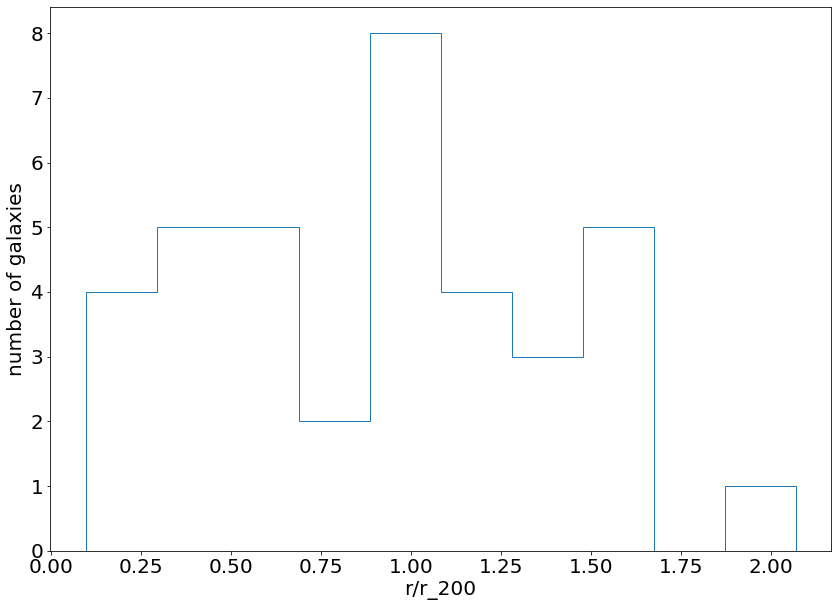

In [7]:
# lets test somo clean up by separation.
R200, GalCen, GroCen = [], [], []

for ss, cc in zip(Satellites, Centrals):
    group = sim['SnapNumber_128/SubGroups/GroupNumber'][cc]
    r200 = sim['SnapNumber_128/Groups/Group_R_Crit200'][group]
    galCen = sim['SnapNumber_128/SubGroups/SubGroupPos'][ss]
    groCen = sim['SnapNumber_128/SubGroups/SubGroupPos'][cc]
    
    R200.append(r200)
    GalCen.append(galCen)
    GroCen.append(groCen)

R200, GalCen, GroCen = np.array(R200), np.array(GalCen), np.array(GroCen)

sep = GalCen - GroCen
dist = np.sqrt(sep[:,0]**2+sep[:,1]**2+sep[:,2]**2)
dist = dist/R200

# Satellites = Slist['SatelliteList'][()]
# Centrals = Slist['SatelliteCentral'][()]
# CosCen = Slist['CosCen'][()]
# CosVel = Slist['CosVel'][()]
# LzL = Slist['LZ_L'][()]

pl.figure(figsize=(14, 10))

pl.hist(dist, histtype='step')
pl.ylabel('number of galaxies')
pl.xlabel('r/r_200')

In [8]:
ir = np.where(dist>0.5)

Satellites = Satellites[ir]
Centrals = Centrals[ir]
CosCen = CosCen[ir]
CosVel = CosVel[ir]
LzL = LzL[ir]

Satellites.size, CosCen.min()

(28, -0.9617047452183579)

In [9]:
# lets separate by Cosines
CosCen = np.abs(CosCen)
CosVel = np.abs(CosVel)

medCen = np.median(CosCen)
medVel = np.median(CosVel)

errCen = np.std(CosCen)/np.sqrt(CosCen.size)
errVel = np.std(CosVel)/np.sqrt(CosVel.size)

print(medCen, medVel)
print(errCen, errVel)

i1Cen = np.where(CosCen<0.5)
i2Cen = np.where(CosCen>0.5)

i1Vel = np.where(CosVel<0.5)
i2Vel = np.where(CosVel>0.5)

satC1, centC1 = Satellites[i1Cen], Centrals[i1Cen]
satC2, centC2 = Satellites[i2Cen], Centrals[i2Cen]

satV1, centV1 = Satellites[i1Vel], Centrals[i1Vel]
satV2, centV2 = Satellites[i2Vel], Centrals[i2Vel]

0.5240529098228591 0.5383514022575306
0.04927202072889633 0.046694164739971865


In [10]:
# low cos central
size = satC1.size
# size = 100

bar = progressbar.ProgressBar(max_value=size)
C, passs = 0, 0

XRv_C1, YRv_C1, ZRv_C1, XRc_C1, YRc_C1, ZRc_C1, GASMasses_C1, GASAbundances_C1 = [], [], [], [], [], [], [], []
StarMass_C1 = []

for ff, cc in zip(satC1, centC1):
    try:
        xRv, yRv, zRv, xRc, yRc, zRc, GasMasses, GasAbundances = getAllLastP(ff, cc)
        passs += 1
    except:
        C += 1
        continue
    
    XRv_C1.extend(list(xRv))
    YRv_C1.extend(list(yRv))
    ZRv_C1.extend(list(zRv))
    XRc_C1.extend(list(xRc))
    YRc_C1.extend(list(yRc))
    ZRc_C1.extend(list(zRc))
    GASMasses_C1.extend(list(GasMasses))
    GASAbundances_C1.extend(list(GasAbundances))
    
    # and star masses
    offst = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][ff].astype('int')
    STMass = sim['SnapNumber_128/PartType4/Masses'][offst[0]:offst[1]]
    STM = np.sum(STMass)
    
    StarMass_C1.extend([STM]*xRv.size)
    
    C += 1
    bar.update(C)
    
XRv_C1, YRv_C1, ZRv_C1, XRc_C1, YRc_C1, ZRc_C1, GASMasses_C1, GASAbundances_C1 = np.array(XRv_C1), np.array(YRv_C1), np.array(ZRv_C1), np.array(XRc_C1), np.array(YRc_C1), np.array(ZRc_C1), np.array(GASMasses_C1), np.array(GASAbundances_C1)
StarMass_C1 = np.array(StarMass_C1)
passs

100% (12 of 12) |########################| Elapsed Time: 0:02:23 ETA:  00:00:00

12

In [11]:
 # high cos central
size = satC2.size
# size = 100

bar = progressbar.ProgressBar(max_value=size)
C, passs = 0, 0

XRv_C2, YRv_C2, ZRv_C2, XRc_C2, YRc_C2, ZRc_C2, GASMasses_C2, GASAbundances_C2 = [], [], [], [], [], [], [], []
StarMass_C2 = []

for ff, cc in zip(satC2, centC2):
    try:
        xRv, yRv, zRv, xRc, yRc, zRc, GasMasses, GasAbundances = getAllLastP(ff, cc)
        passs += 1
    except:
        C += 1
        continue
    XRv_C2.extend(list(xRv))
    YRv_C2.extend(list(yRv))
    ZRv_C2.extend(list(zRv))
    XRc_C2.extend(list(xRc))
    YRc_C2.extend(list(yRc))
    ZRc_C2.extend(list(zRc))
    GASMasses_C2.extend(list(GasMasses))
    
    GASAbundances_C2.extend(list(GasAbundances))
    
     # and star masses
    offst = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][ff].astype('int')
    STMass = sim['SnapNumber_128/PartType4/Masses'][offst[0]:offst[1]]
    STM = np.sum(STMass)
    StarMass_C2.extend([STM]*xRv.size)
    
    C += 1
    bar.update(C)
    
XRv_C2, YRv_C2, ZRv_C2, XRc_C2, YRc_C2, ZRc_C2, GASMasses_C2, GASAbundances_C2 = np.array(XRv_C2), np.array(YRv_C2), np.array(ZRv_C2), np.array(XRc_C2), np.array(YRc_C2), np.array(ZRc_C2), np.array(GASMasses_C2), np.array(GASAbundances_C2)
StarMass_C2 = np.array(StarMass_C2)

passs

100% (16 of 16) |########################| Elapsed Time: 0:01:45 ETA:  00:00:00

16

In [12]:
# low cos velocity
size = satV1.size
# size = 100

bar = progressbar.ProgressBar(max_value=size)
C, passs = 0, 0

XRv_V1, YRv_V1, ZRv_V1, XRc_V1, YRc_V1, ZRc_V1, GASMasses_V1, GASAbundances_V1 = [], [], [], [], [], [], [], []
StarMass_V1 = []


for ff, cc in zip(satV1, centV1):
    try:
        xRv, yRv, zRv, xRc, yRc, zRc, GasMasses, GasAbundances = getAllLastP(ff, cc)
        passs += 1
    except:
        C += 1
        continue
    XRv_V1.extend(list(xRv))
    YRv_V1.extend(list(yRv))
    ZRv_V1.extend(list(zRv))
    XRc_V1.extend(list(xRc))
    YRc_V1.extend(list(yRc))
    ZRc_V1.extend(list(zRc))
    GASMasses_V1.extend(list(GasMasses))
    
    GASAbundances_V1.extend(list(GasAbundances))
    
    # and star masses
    offst = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][ff].astype('int')
    STMass = sim['SnapNumber_128/PartType4/Masses'][offst[0]:offst[1]]
    STM = np.sum(STMass)
    StarMass_V1.extend([STM]*xRv.size)
    
    C += 1
    bar.update(C)
    
XRv_V1, YRv_V1, ZRv_V1, XRc_V1, YRc_V1, ZRc_V1, GASMasses_V1, GASAbundances_V1 = np.array(XRv_V1), np.array(YRv_V1), np.array(ZRv_V1), np.array(XRc_V1), np.array(YRc_V1), np.array(ZRc_V1), np.array(GASMasses_V1), np.array(GASAbundances_V1)
StarMass_V1 = np.array(StarMass_V1)

passs

100% (12 of 12) |########################| Elapsed Time: 0:00:42 ETA:  00:00:00

12

In [13]:
# low cos velocity
size = satV2.size
# size = 100

bar = progressbar.ProgressBar(max_value=size)
C, passs = 0, 0

XRv_V2, YRv_V2, ZRv_V2, XRc_V2, YRc_V2, ZRc_V2, GASMasses_V2, GASAbundances_V2 = [], [], [], [], [], [], [], []
StarMass_V2 = []

for ff, cc in zip(satV2, centV2):
    try:
        xRv, yRv, zRv, xRc, yRc, zRc, GasMasses, GasAbundances = getAllLastP(ff, cc)
        passs += 1
    except:
        C += 1
        continue
    XRv_V2.extend(list(xRv))
    YRv_V2.extend(list(yRv))
    ZRv_V2.extend(list(zRv))
    XRc_V2.extend(list(xRc))
    YRc_V2.extend(list(yRc))
    ZRc_V2.extend(list(zRc))
    GASMasses_V2.extend(list(GasMasses))
    
    GASAbundances_V2.extend(list(GasAbundances))
    
    # and star masses
    offst = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][ff].astype('int')
    STMass = sim['SnapNumber_128/PartType4/Masses'][offst[0]:offst[1]]
    STM = np.sum(STMass)
    StarMass_V2.extend([STM]*xRv.size)
    
    C += 1
    bar.update(C)
    
XRv_V2, YRv_V2, ZRv_V2, XRc_V2, YRc_V2, ZRc_V2, GASMasses_V2, GASAbundances_V2 = np.array(XRv_V2), np.array(YRv_V2), np.array(ZRv_V2), np.array(XRc_V2), np.array(YRc_V2), np.array(ZRc_V2), np.array(GASMasses_V2), np.array(GASAbundances_V2)
StarMass_V2 = np.array(StarMass_V2)

passs

100% (16 of 16) |########################| Elapsed Time: 0:03:10 ETA:  00:00:00

16

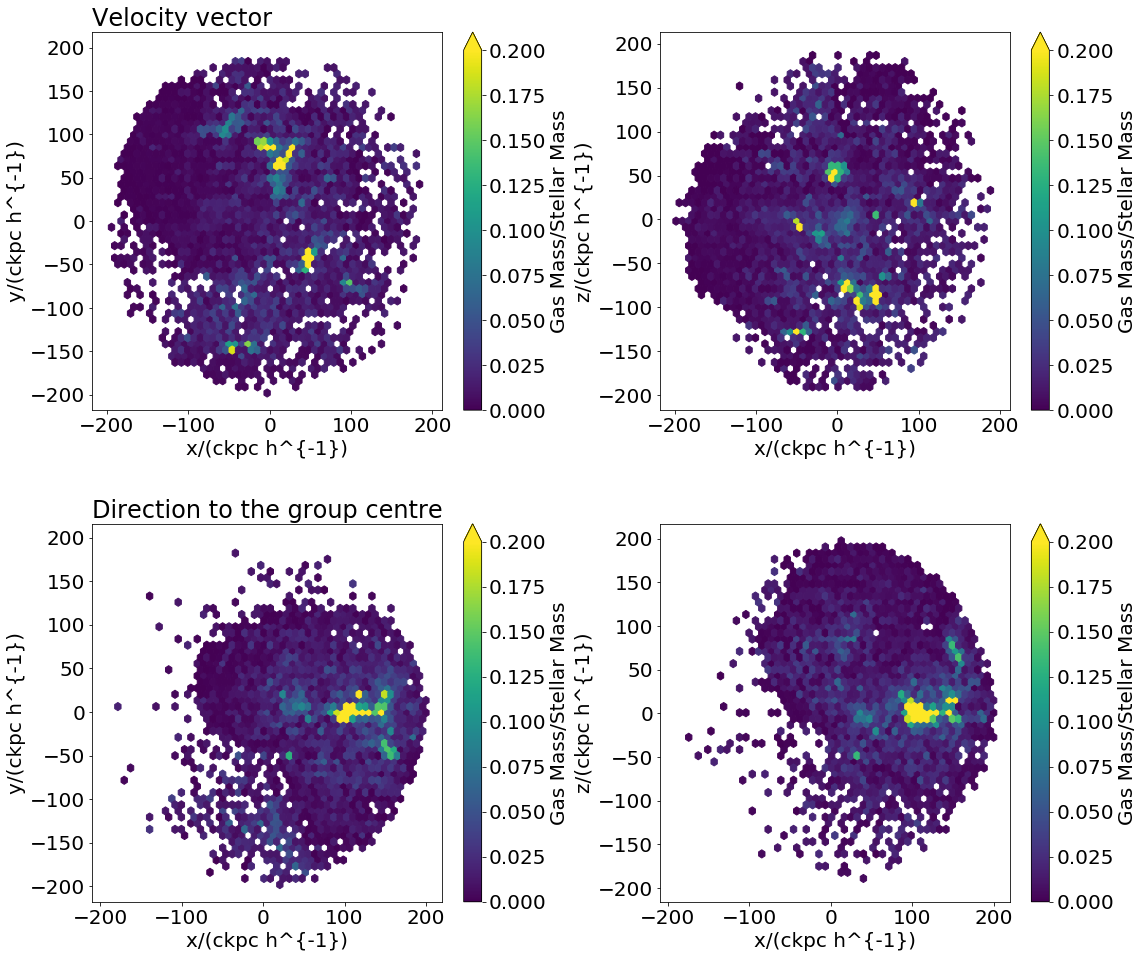

In [14]:
# Centrals low C1
pl.figure(figsize=(18, 16))

pl.subplots_adjust(wspace=0.3, hspace=0.3)

pl.subplot(2, 2, 1)

pl.title('Velocity vector',loc='left')

pl.hexbin(XRv_C1, YRv_C1, C=GASMasses_C1/StarMass_C1, gridsize=50, bins=None, mincnt=1, reduce_C_function=np.sum, vmin=0, vmax=0.2)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('y/(ckpc h^{-1})')

bar = pl.colorbar(label='Gas Mass/Stellar Mass', extend='max')

pl.subplot(2, 2, 2)

pl.hexbin(XRv_C1, ZRv_C1, C=GASMasses_C1/StarMass_C1, gridsize=50, bins=None, mincnt=1, reduce_C_function=np.sum, vmin=0, vmax=0.2)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('z/(ckpc h^{-1})')

bar = pl.colorbar(label='Gas Mass/Stellar Mass', extend='max')

pl.subplot(2, 2, 3)

pl.title('Direction to the group centre', loc='left')

pl.hexbin(XRc_C1, YRc_C1, C=GASMasses_C1/StarMass_C1, gridsize=50, bins=None, mincnt=1, reduce_C_function=np.sum, vmin=0., vmax=0.2)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('y/(ckpc h^{-1})')

bar = pl.colorbar(label='Gas Mass/Stellar Mass', extend='max')

pl.subplot(2, 2, 4)

pl.hexbin(XRc_C1, ZRc_C1, C=GASMasses_C1/StarMass_C1, gridsize=50, bins=None, mincnt=1, reduce_C_function=np.sum, vmin=0., vmax=0.2)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('z/(ckpc h^{-1})')

bar = pl.colorbar(label='Gas Mass/Stellar Mass', extend='max')

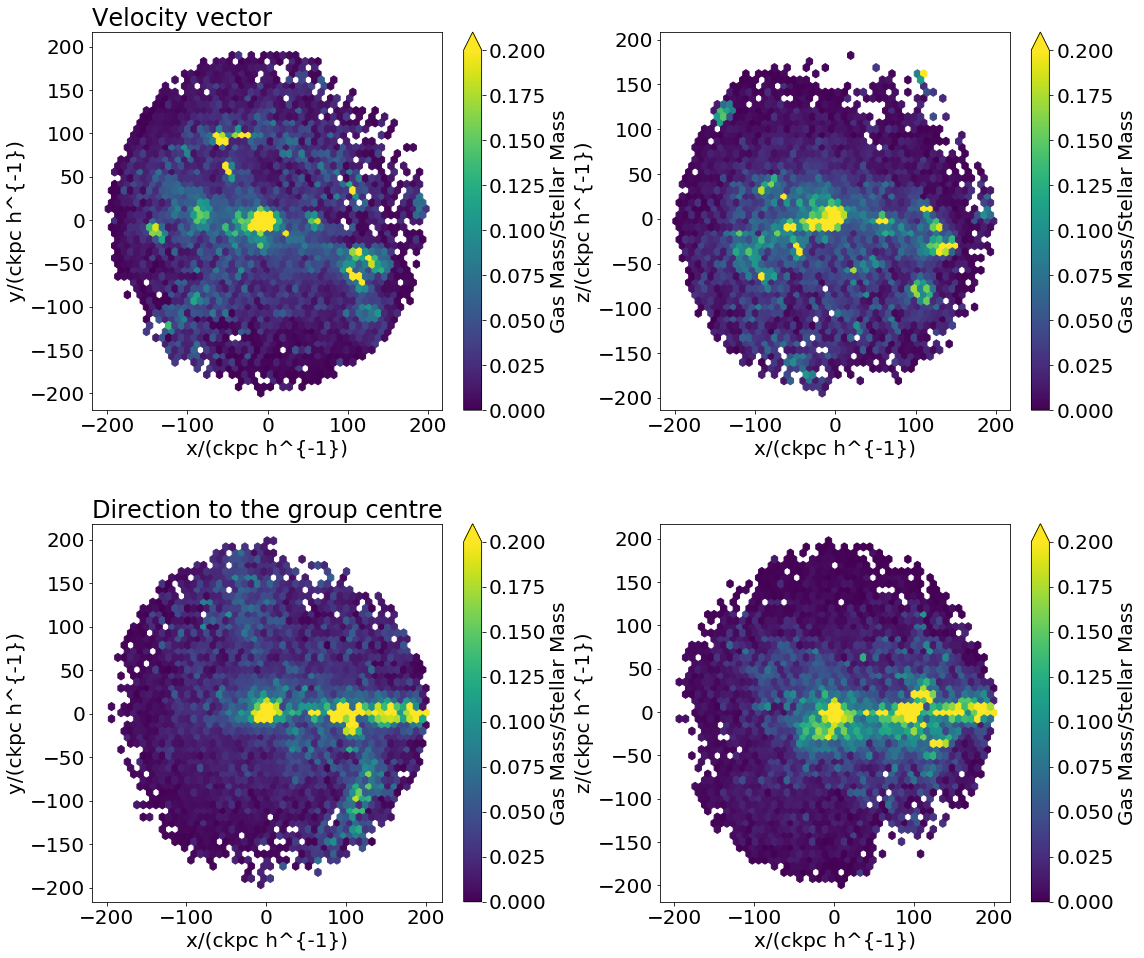

In [15]:
# Centrals high C1
pl.figure(figsize=(18, 16))

pl.subplots_adjust(wspace=0.3, hspace=0.3)

pl.subplot(2, 2, 1)

pl.title('Velocity vector',loc='left')

pl.hexbin(XRv_C2, YRv_C2, C=GASMasses_C2/StarMass_C2, gridsize=50, bins=None, mincnt=1, reduce_C_function=np.sum, vmin=0., vmax=0.2)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('y/(ckpc h^{-1})')

bar = pl.colorbar(label='Gas Mass/Stellar Mass', extend='max')

pl.subplot(2, 2, 2)

pl.hexbin(XRv_C2, ZRv_C2, C=GASMasses_C2/StarMass_C2, gridsize=50, bins=None, mincnt=1, reduce_C_function=np.sum, vmin=0., vmax=0.2)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('z/(ckpc h^{-1})')

bar = pl.colorbar(label='Gas Mass/Stellar Mass', extend='max')
pl.subplot(2, 2, 3)

pl.title('Direction to the group centre', loc='left')

pl.hexbin(XRc_C2, YRc_C2, C=GASMasses_C2/StarMass_C2, gridsize=50, bins=None, mincnt=1, reduce_C_function=np.sum, vmin=0., vmax=0.2)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('y/(ckpc h^{-1})')

bar = pl.colorbar(label='Gas Mass/Stellar Mass', extend='max')

pl.subplot(2, 2, 4)

pl.hexbin(XRc_C2, ZRc_C2, C=GASMasses_C2/StarMass_C2, gridsize=50, bins=None, mincnt=1, reduce_C_function=np.sum, vmin=0., vmax=0.2)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('z/(ckpc h^{-1})')

bar = pl.colorbar(label='Gas Mass/Stellar Mass', extend='max')

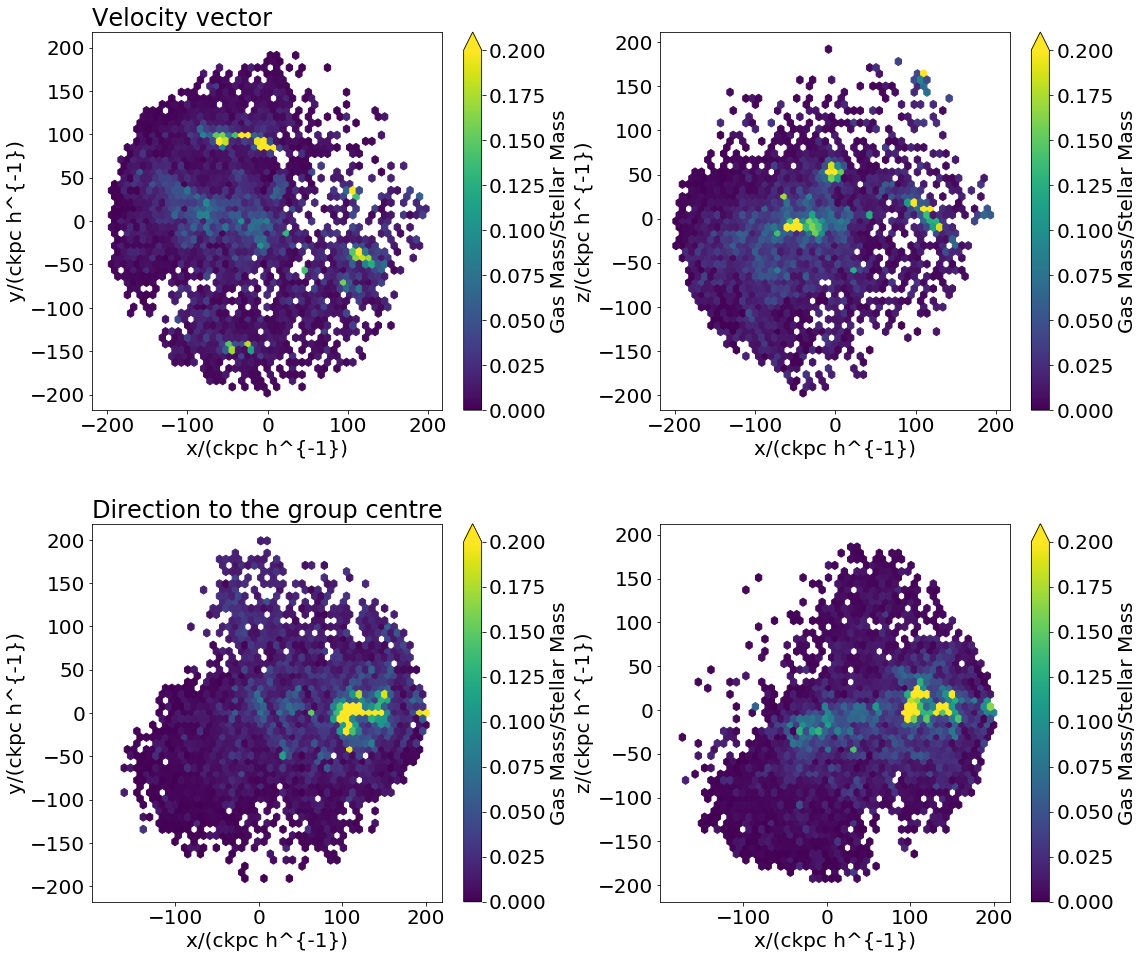

In [16]:
# Centrals low Velocity
pl.figure(figsize=(18, 16))

pl.subplots_adjust(wspace=0.3, hspace=0.3)

pl.subplot(2, 2, 1)

pl.title('Velocity vector',loc='left')

pl.hexbin(XRv_V1, YRv_V1, C=GASMasses_V1/StarMass_V1, gridsize=50, bins=None, mincnt=1, reduce_C_function=np.sum, vmin=0., vmax=0.2)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('y/(ckpc h^{-1})')

bar = pl.colorbar(label='Gas Mass/Stellar Mass', extend='max')

pl.subplot(2, 2, 2)

pl.hexbin(XRv_V1, ZRv_V1, C=GASMasses_V1/StarMass_V1, gridsize=50, bins=None, mincnt=1, reduce_C_function=np.sum, vmin=0., vmax=0.2)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('z/(ckpc h^{-1})')

bar = pl.colorbar(label='Gas Mass/Stellar Mass', extend='max')

pl.subplot(2, 2, 3)

pl.title('Direction to the group centre', loc='left')

pl.hexbin(XRc_V1, YRc_V1, C=GASMasses_V1/StarMass_V1, gridsize=50, bins=None, mincnt=1, reduce_C_function=np.sum, vmin=0., vmax=0.2)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('y/(ckpc h^{-1})')

bar = pl.colorbar(label='Gas Mass/Stellar Mass', extend='max')

pl.subplot(2, 2, 4)

pl.hexbin(XRc_V1, ZRc_V1, C=GASMasses_V1/StarMass_V1, gridsize=50, bins=None, mincnt=1, reduce_C_function=np.sum, vmin=0., vmax=0.2)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('z/(ckpc h^{-1})')

bar = pl.colorbar(label='Gas Mass/Stellar Mass', extend='max')

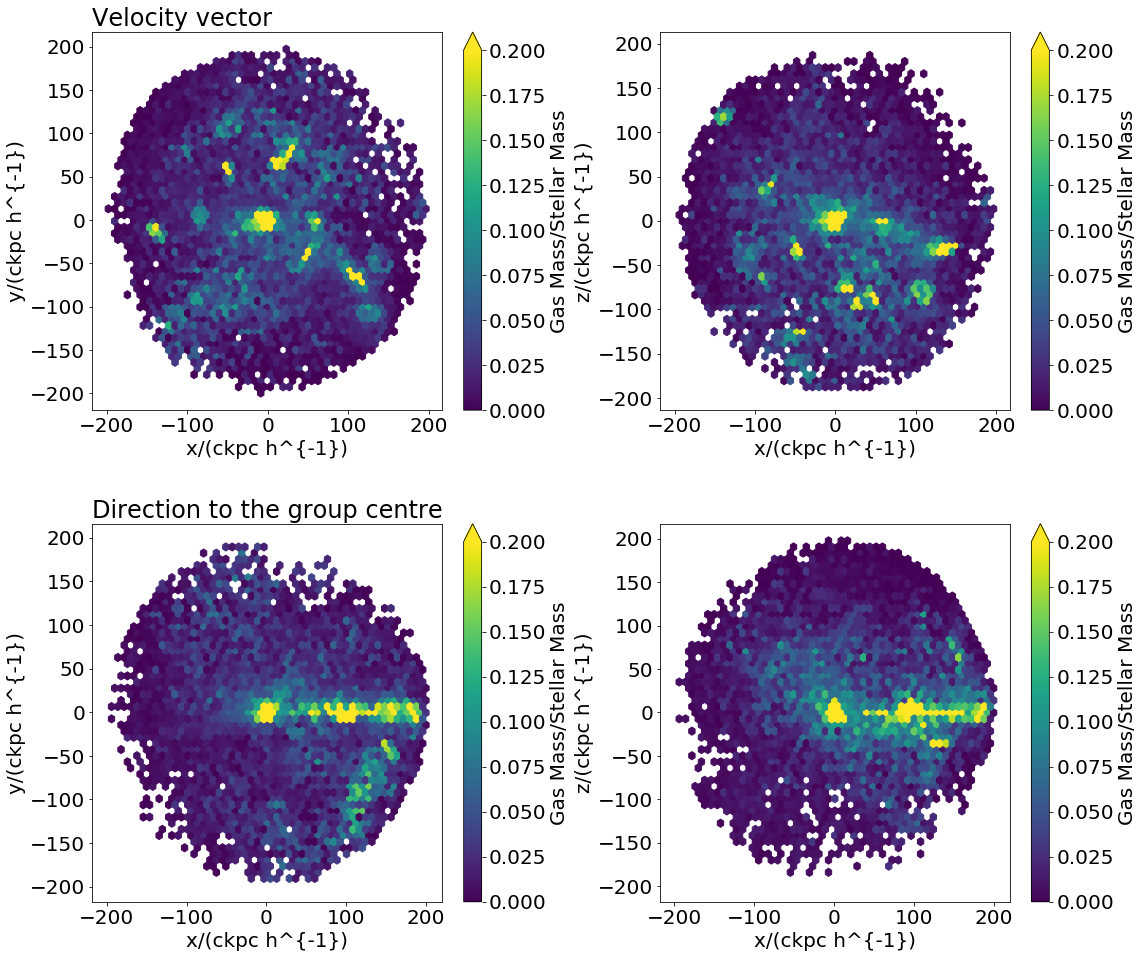

In [17]:
# Centrals high Velocity
pl.figure(figsize=(18, 16))

pl.subplots_adjust(wspace=0.3, hspace=0.3)

pl.subplot(2, 2, 1)

pl.title('Velocity vector',loc='left')

pl.hexbin(XRv_V2, YRv_V2, C=GASMasses_V2/StarMass_V2, gridsize=50, bins=None, mincnt=1, reduce_C_function=np.sum, vmin=0., vmax=0.2)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('y/(ckpc h^{-1})')

bar = pl.colorbar(label='Gas Mass/Stellar Mass', extend='max')

pl.subplot(2, 2, 2)

pl.hexbin(XRv_V2, ZRv_V2, C=GASMasses_V2/StarMass_V2, gridsize=50, bins=None, mincnt=1, reduce_C_function=np.sum, vmin=0., vmax=0.2)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('z/(ckpc h^{-1})')

bar = pl.colorbar(label='Gas Mass/Stellar Mass', extend='max')

pl.subplot(2, 2, 3)

pl.title('Direction to the group centre', loc='left')

pl.hexbin(XRc_V2, YRc_V2, C=GASMasses_V2/StarMass_V2, gridsize=50, bins=None, mincnt=1, reduce_C_function=np.sum, vmin=0., vmax=0.2)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('y/(ckpc h^{-1})')

bar = pl.colorbar(label='Gas Mass/Stellar Mass', extend='max')

pl.subplot(2, 2, 4)

pl.hexbin(XRc_V2, ZRc_V2, C=GASMasses_V2/StarMass_V2, gridsize=50, bins=None, mincnt=1, reduce_C_function=np.sum, vmin=0., vmax=0.2)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('z/(ckpc h^{-1})')

bar = pl.colorbar(label='Gas Mass/Stellar Mass', extend='max')

In [18]:
np.sum(GASMasses_C1), np.sum(GASMasses_C2), np.sum(GASMasses_V1), np.sum(GASMasses_V2)

(0.3458764, 0.79537874, 0.29384467, 0.8474103)

In [19]:
np.sum(GASMasses_C1/StarMass_C1), np.sum(GASMasses_C2/StarMass_C2), np.sum(GASMasses_V1/StarMass_V1), np.sum(GASMasses_V2/StarMass_V2)

(30.655123, 66.66457, 31.32446, 65.99524)

In [20]:
np.sum(GASMasses_C1)/np.sum(np.unique(StarMass_C1)), np.sum(GASMasses_C2)/np.sum(np.unique(StarMass_C2)), np.sum(GASMasses_V1)/np.sum(np.unique(StarMass_V1)), np.sum(GASMasses_V2)/np.sum(np.unique(StarMass_V2))

(0.758614, 3.5892978, 1.8183532, 1.6424911)

In [21]:
GASMasses_C1.size, GASMasses_C2.size, GASMasses_V1.size, GASMasses_V2.size

(18327, 42548, 15747, 45128)

In [22]:
np.mean(GASMasses_C1/StarMass_C1), np.mean(GASMasses_C2/StarMass_C2), np.mean(GASMasses_V1/StarMass_V1), np.mean(GASMasses_V2/StarMass_V2)

(0.0016726755, 0.0015668087, 0.0019892335, 0.0014624011)

(array([17.,  6.,  1.,  1.,  0.,  0.,  2.,  0.,  0.,  0.]),
 array([0.e+00, 1.e+08, 2.e+08, 3.e+08, 4.e+08, 5.e+08, 6.e+08, 7.e+08,
        8.e+08, 9.e+08, 1.e+09], dtype=float32),
 <a list of 10 Patch objects>)

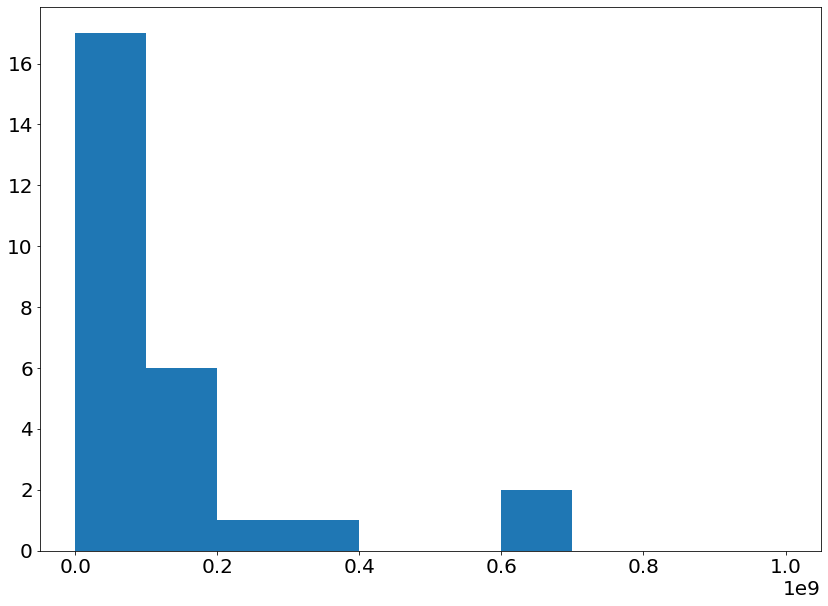

In [23]:
# sooo, i need masses, lets see how different are the masses of the galaxies.

Mass = []

for ss, cc in zip(Satellites, Centrals):
    offs = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][ss].astype('int')
    Masses = sim['SnapNumber_128/PartType4/Masses'][offs[0]:offs[1]]
    Mass.append(np.sum(Masses))
    
Mass = np.array(Mass)*1e10


pl.figure(figsize=(14,10))

pl.hist(Mass, range=(0, 10e8))

In [24]:
iMass = np.where(Mass<6e8)

Satellites = Satellites[iMass]
Centrals = Centrals[iMass]
CosCen = CosCen[iMass]
CosVel = CosVel[iMass]
LzL = LzL[iMass]

Satellites.size, CosCen.min()

(25, 0.0748351855066956)

In [25]:
medCen = np.median(CosCen)
medVel = np.median(CosVel)


i1Cen = np.where(CosCen<medCen)
i2Cen = np.where(CosCen>medCen)

i1Vel = np.where(CosVel<medVel)
i2Vel = np.where(CosVel>medVel)

satC1, centC1 = Satellites[i1Cen], Centrals[i1Cen]
satC2, centC2 = Satellites[i2Cen], Centrals[i2Cen]

satV1, centV1 = Satellites[i1Vel], Centrals[i1Vel]
satV2, centV2 = Satellites[i2Vel], Centrals[i2Vel]

In [26]:
# low cos central
size = satC1.size
# size = 100

bar = progressbar.ProgressBar(max_value=size)
C, passs = 0, 0

XRv_C1, YRv_C1, ZRv_C1, XRc_C1, YRc_C1, ZRc_C1, GASMasses_C1, GASAbundances_C1 = [], [], [], [], [], [], [], []

for ff, cc in zip(satC1, centC1):
    try:
        xRv, yRv, zRv, xRc, yRc, zRc, GasMasses, GasAbundances = getAllLastP(ff, cc)
        passs += 1
    except:
        C += 1
        continue
    XRv_C1.extend(list(xRv))
    YRv_C1.extend(list(yRv))
    ZRv_C1.extend(list(zRv))
    XRc_C1.extend(list(xRc))
    YRc_C1.extend(list(yRc))
    ZRc_C1.extend(list(zRc))
    GASMasses_C1.extend(list(GasMasses))
    
    GASAbundances_C1.extend(list(GasAbundances))
    C += 1
    bar.update(C)
    
XRv_C1, YRv_C1, ZRv_C1, XRc_C1, YRc_C1, ZRc_C1, GASMasses_C1, GASAbundances_C1 = np.array(XRv_C1), np.array(YRv_C1), np.array(ZRv_C1), np.array(XRc_C1), np.array(YRc_C1), np.array(ZRc_C1), np.array(GASMasses_C1), np.array(GASAbundances_C1)
passs

100% (12 of 12) |########################| Elapsed Time: 0:00:32 ETA:  00:00:00

12

In [27]:
# high cos central
size = satC2.size
# size = 100

bar = progressbar.ProgressBar(max_value=size)
C, passs = 0, 0

XRv_C2, YRv_C2, ZRv_C2, XRc_C2, YRc_C2, ZRc_C2, GASMasses_C2, GASAbundances_C2 = [], [], [], [], [], [], [], []

for ff, cc in zip(satC2, centC2):
    try:
        xRv, yRv, zRv, xRc, yRc, zRc, GasMasses, GasAbundances = getAllLastP(ff, cc)
        passs += 1
    except:
        C += 1
        continue
    XRv_C2.extend(list(xRv))
    YRv_C2.extend(list(yRv))
    ZRv_C2.extend(list(zRv))
    XRc_C2.extend(list(xRc))
    YRc_C2.extend(list(yRc))
    ZRc_C2.extend(list(zRc))
    GASMasses_C2.extend(list(GasMasses))
    
    GASAbundances_C2.extend(list(GasAbundances))
    C += 1
    bar.update(C)
    
XRv_C2, YRv_C2, ZRv_C2, XRc_C2, YRc_C2, ZRc_C2, GASMasses_C2, GASAbundances_C2 = np.array(XRv_C2), np.array(YRv_C2), np.array(ZRv_C2), np.array(XRc_C2), np.array(YRc_C2), np.array(ZRc_C2), np.array(GASMasses_C2), np.array(GASAbundances_C2)
passs

100% (12 of 12) |########################| Elapsed Time: 0:00:43 ETA:  00:00:00

12

In [28]:
# low cos velocity
size = satV1.size
# size = 100

bar = progressbar.ProgressBar(max_value=size)
C, passs = 0, 0

XRv_V1, YRv_V1, ZRv_V1, XRc_V1, YRc_V1, ZRc_V1, GASMasses_V1, GASAbundances_V1 = [], [], [], [], [], [], [], []

for ff, cc in zip(satV1, centV1):
    try:
        xRv, yRv, zRv, xRc, yRc, zRc, GasMasses, GasAbundances = getAllLastP(ff, cc)
        passs += 1
    except:
        C += 1
        continue
    XRv_V1.extend(list(xRv))
    YRv_V1.extend(list(yRv))
    ZRv_V1.extend(list(zRv))
    XRc_V1.extend(list(xRc))
    YRc_V1.extend(list(yRc))
    ZRc_V1.extend(list(zRc))
    GASMasses_V1.extend(list(GasMasses))
    
    GASAbundances_V1.extend(list(GasAbundances))
    C += 1
    bar.update(C)
    
XRv_V1, YRv_V1, ZRv_V1, XRc_V1, YRc_V1, ZRc_V1, GASMasses_V1, GASAbundances_V1 = np.array(XRv_V1), np.array(YRv_V1), np.array(ZRv_V1), np.array(XRc_V1), np.array(YRc_V1), np.array(ZRc_V1), np.array(GASMasses_V1), np.array(GASAbundances_V1)
passs

100% (12 of 12) |########################| Elapsed Time: 0:00:33 ETA:  00:00:00

12

In [29]:
# low cos velocity
size = satV2.size
# size = 100

bar = progressbar.ProgressBar(max_value=size)
C, passs = 0, 0

XRv_V2, YRv_V2, ZRv_V2, XRc_V2, YRc_V2, ZRc_V2, GASMasses_V2, GASAbundances_V2 = [], [], [], [], [], [], [], []

for ff, cc in zip(satV2, centV2):
    try:
        xRv, yRv, zRv, xRc, yRc, zRc, GasMasses, GasAbundances = getAllLastP(ff, cc)
        passs += 1
    except:
        C += 1
        continue
    XRv_V2.extend(list(xRv))
    YRv_V2.extend(list(yRv))
    ZRv_V2.extend(list(zRv))
    XRc_V2.extend(list(xRc))
    YRc_V2.extend(list(yRc))
    ZRc_V2.extend(list(zRc))
    GASMasses_V2.extend(list(GasMasses))
    
    GASAbundances_V2.extend(list(GasAbundances))
    C += 1
    bar.update(C)
    
XRv_V2, YRv_V2, ZRv_V2, XRc_V2, YRc_V2, ZRc_V2, GASMasses_V2, GASAbundances_V2 = np.array(XRv_V2), np.array(YRv_V2), np.array(ZRv_V2), np.array(XRc_V2), np.array(YRc_V2), np.array(ZRc_V2), np.array(GASMasses_V2), np.array(GASAbundances_V2)
passs

100% (12 of 12) |########################| Elapsed Time: 0:00:42 ETA:  00:00:00

12

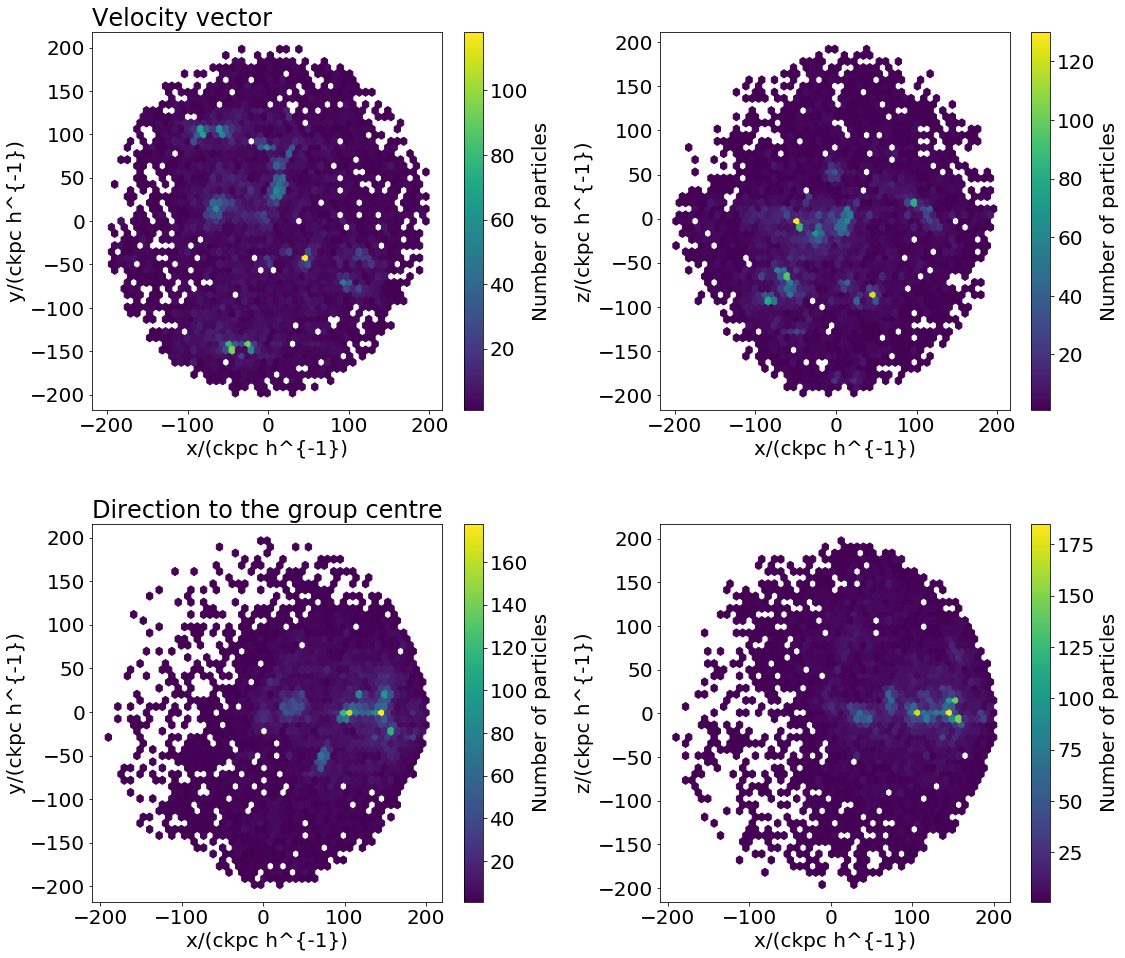

In [30]:
# Centrals low C1
pl.figure(figsize=(18, 16))

pl.subplots_adjust(wspace=0.3, hspace=0.3)

pl.subplot(2, 2, 1)

pl.title('Velocity vector',loc='left')

pl.hexbin(XRv_C1, YRv_C1, gridsize=50, bins=None, mincnt=1)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('y/(ckpc h^{-1})')

bar = pl.colorbar(label='Number of particles')

pl.subplot(2, 2, 2)

pl.hexbin(XRv_C1, ZRv_C1, gridsize=50, bins=None, mincnt=1)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('z/(ckpc h^{-1})')

bar = pl.colorbar(label='Number of particles')

pl.subplot(2, 2, 3)

pl.title('Direction to the group centre', loc='left')

pl.hexbin(XRc_C1, YRc_C1, gridsize=50, bins=None, mincnt=1)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('y/(ckpc h^{-1})')

bar = pl.colorbar(label='Number of particles')

pl.subplot(2, 2, 4)

pl.hexbin(XRc_C1, ZRc_C1, gridsize=50, bins=None, mincnt=1)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('z/(ckpc h^{-1})')

bar = pl.colorbar(label='Number of particles')

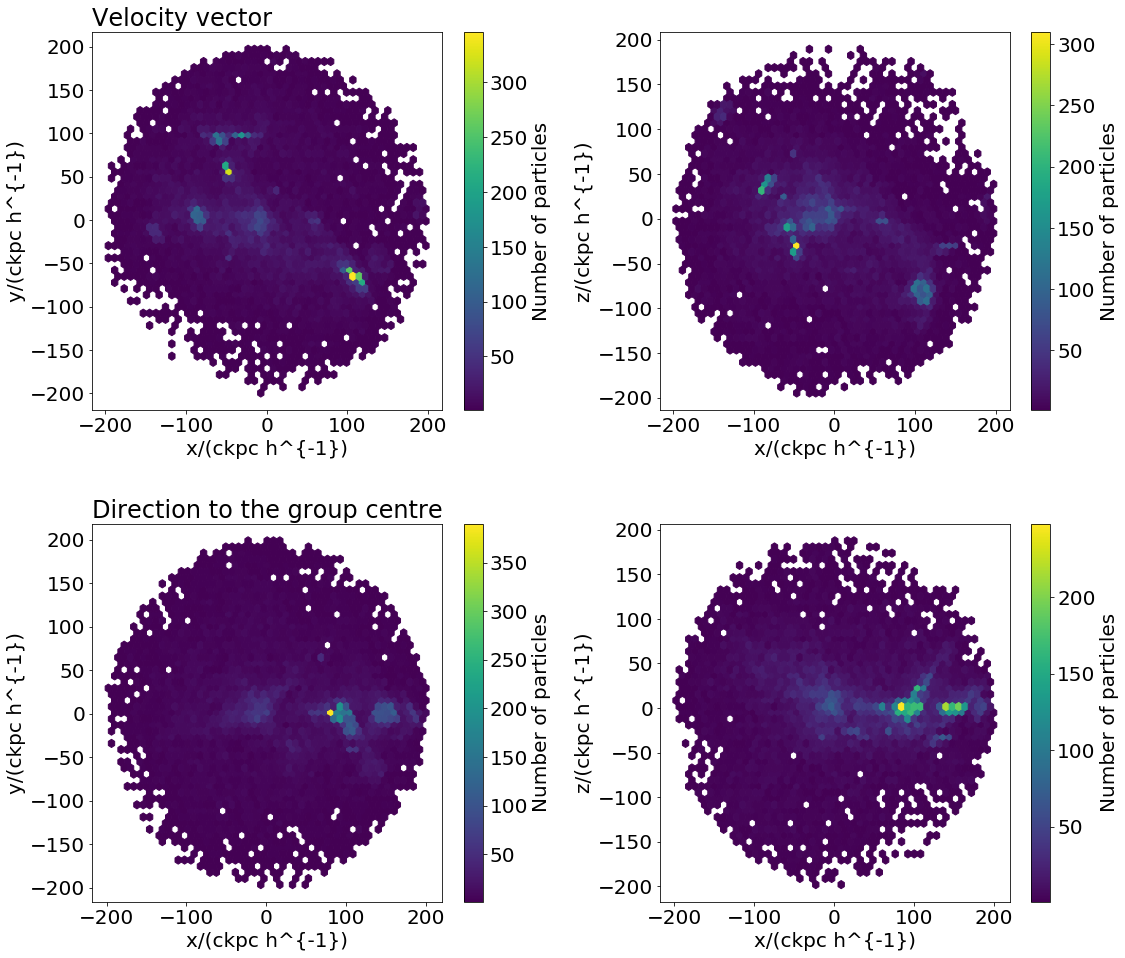

In [31]:
# Centrals high C1
pl.figure(figsize=(18, 16))

pl.subplots_adjust(wspace=0.3, hspace=0.3)

pl.subplot(2, 2, 1)

pl.title('Velocity vector',loc='left')

pl.hexbin(XRv_C2, YRv_C2, gridsize=50, bins=None, mincnt=1)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('y/(ckpc h^{-1})')

bar = pl.colorbar(label='Number of particles')

pl.subplot(2, 2, 2)

pl.hexbin(XRv_C2, ZRv_C2, gridsize=50, bins=None, mincnt=1)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('z/(ckpc h^{-1})')

bar = pl.colorbar(label='Number of particles')

pl.subplot(2, 2, 3)

pl.title('Direction to the group centre', loc='left')

pl.hexbin(XRc_C2, YRc_C2, gridsize=50, bins=None, mincnt=1)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('y/(ckpc h^{-1})')

bar = pl.colorbar(label='Number of particles')

pl.subplot(2, 2, 4)

pl.hexbin(XRc_C2, ZRc_C2, gridsize=50, bins=None, mincnt=1)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('z/(ckpc h^{-1})')

bar = pl.colorbar(label='Number of particles')

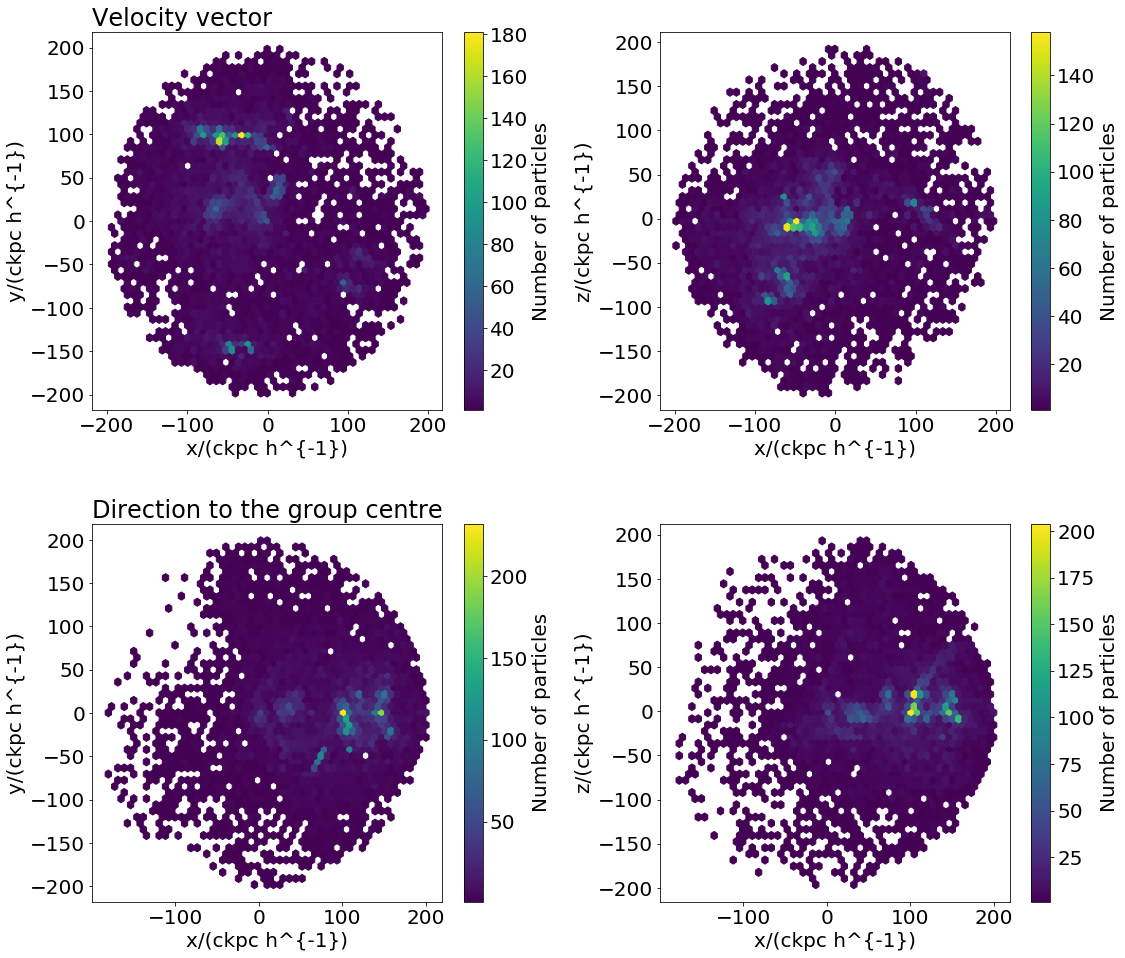

In [32]:
# Centrals low Velocity
pl.figure(figsize=(18, 16))

pl.subplots_adjust(wspace=0.3, hspace=0.3)

pl.subplot(2, 2, 1)

pl.title('Velocity vector',loc='left')

pl.hexbin(XRv_V1, YRv_V1, gridsize=50, bins=None, mincnt=1)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('y/(ckpc h^{-1})')

bar = pl.colorbar(label='Number of particles')

pl.subplot(2, 2, 2)

pl.hexbin(XRv_V1, ZRv_V1, gridsize=50, bins=None, mincnt=1)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('z/(ckpc h^{-1})')

bar = pl.colorbar(label='Number of particles')

pl.subplot(2, 2, 3)

pl.title('Direction to the group centre', loc='left')

pl.hexbin(XRc_V1, YRc_V1, gridsize=50, bins=None, mincnt=1)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('y/(ckpc h^{-1})')

bar = pl.colorbar(label='Number of particles')

pl.subplot(2, 2, 4)

pl.hexbin(XRc_V1, ZRc_V1, gridsize=50, bins=None, mincnt=1)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('z/(ckpc h^{-1})')

bar = pl.colorbar(label='Number of particles')

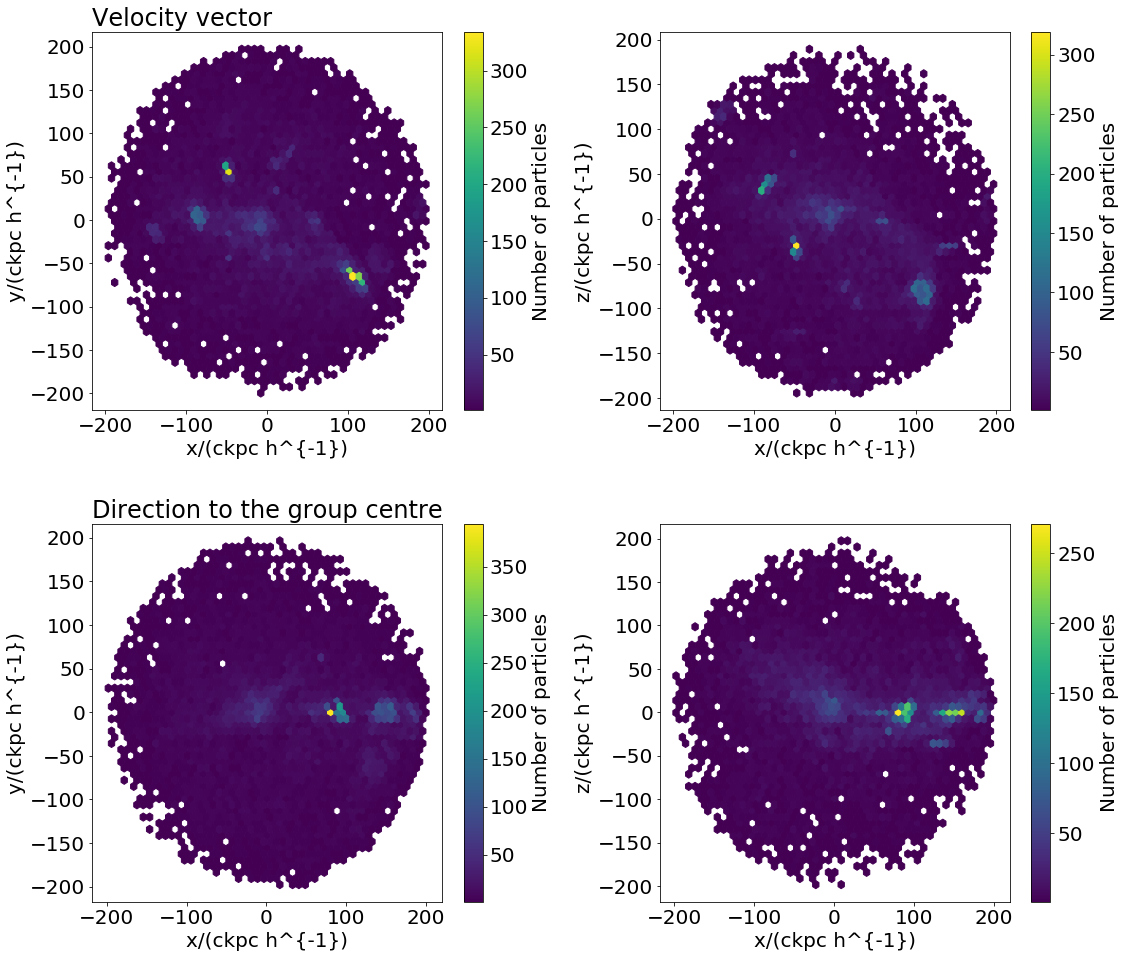

In [33]:
# Centrals high Velocity
pl.figure(figsize=(18, 16))

pl.subplots_adjust(wspace=0.3, hspace=0.3)

pl.subplot(2, 2, 1)

pl.title('Velocity vector',loc='left')

pl.hexbin(XRv_V2, YRv_V2, gridsize=50, bins=None, mincnt=1)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('y/(ckpc h^{-1})')

bar = pl.colorbar(label='Number of particles')

pl.subplot(2, 2, 2)

pl.hexbin(XRv_V2, ZRv_V2, gridsize=50, bins=None, mincnt=1)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('z/(ckpc h^{-1})')

bar = pl.colorbar(label='Number of particles')

pl.subplot(2, 2, 3)

pl.title('Direction to the group centre', loc='left')

pl.hexbin(XRc_V2, YRc_V2, gridsize=50, bins=None, mincnt=1)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('y/(ckpc h^{-1})')

bar = pl.colorbar(label='Number of particles')

pl.subplot(2, 2, 4)

pl.hexbin(XRc_V2, ZRc_V2, gridsize=50, bins=None, mincnt=1)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('z/(ckpc h^{-1})')

bar = pl.colorbar(label='Number of particles')

In [34]:
np.sum(GASMasses_C1), np.sum(GASMasses_C2), np.sum(GASMasses_V1), np.sum(GASMasses_V2)

(0.17100626, 0.34127668, 0.19400398, 0.3172336)

In [35]:
TMassC1, TMassC2, TMassV1, TMassV2 = [], [], [], []

for s in satC1:
    off = sim['SnapNumber_128/SubGroups/PartType0/Offsets'][s].astype('int')
    if off[0] >= 0 and off[1] >= 0:
        mass = sim['SnapNumber_128/PartType0/Masses'][off[0]:off[1]]
        TMassC1.extend(list(mass))

for s in satC2:
    off = sim['SnapNumber_128/SubGroups/PartType0/Offsets'][s].astype('int')
    if off[0] >= 0 and off[1] >= 0:
        mass = sim['SnapNumber_128/PartType0/Masses'][off[0]:off[1]]
        TMassC2.extend(list(mass))
        
for s in satV1:
    off = sim['SnapNumber_128/SubGroups/PartType0/Offsets'][s].astype('int')
    if off[0] >= 0 and off[1] >= 0:
        mass = sim['SnapNumber_128/PartType0/Masses'][off[0]:off[1]]
        TMassV1.extend(list(mass))

for s in satV2:
    off = sim['SnapNumber_128/SubGroups/PartType0/Offsets'][s].astype('int')
    if off[0] >= 0 and off[1] >= 0:
        mass = sim['SnapNumber_128/PartType0/Masses'][off[0]:off[1]]
        TMassV2.extend(list(mass))

In [36]:
np.sum(GASMasses_C1)/np.sum(TMassC1), np.sum(GASMasses_C2)/np.sum(TMassC2), np.sum(GASMasses_V1)/np.sum(TMassV1), np.sum(GASMasses_V2)/np.sum(TMassV2)

(1.904185, 9.317984, 2.0271447, 9.349371)